In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import math
from typing import Optional, List
import copy
import numpy as np

import torch
from torch import nn, Tensor
import torchvision
from torchvision.models import resnet50, resnet101
import torchvision.transforms as T
import torch.nn.functional as F
torch.set_grad_enabled(False);

In [2]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.joiner import Joiner
from models.losses import Attention_penalty_factor
from models.unet import UNet

In [3]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'

im = Image.open(requests.get(url, stream=True).raw)

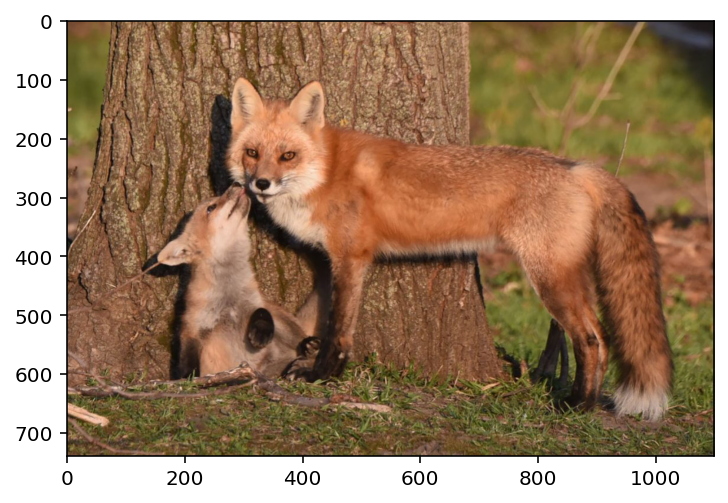

In [4]:
plt.plot()
plt.imshow(im)

In [5]:
H = 180
W=180

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
unet = UNet(3,3)
backbone = Backbone()
encoder = EncoderModule()
model = Joiner(backbone, encoder, hidden_dim=512, image_h=H, image_w=W)

In [7]:
img = transform(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 180, 180])


In [8]:
noise = unet(img)

In [9]:
def model_test(im, model):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # propagate through the model
    #output = model(img)
    output, att_map, sattn, f_map, pos, pattn = model(img)
    return output, att_map, sattn, f_map, pos, pattn

In [10]:
outputs, att, sattn, f_map, pos, pattn = model_test(im,model)

torch.Size([1, 1024, 12, 12])


In [12]:
print("Output shape:", outputs.shape)
print("Feature Map shape:", f_map.shape)
print("Attention Maps shape:", sattn.shape)
print("Encoder output shape:", att.shape)
print("Positional Encoding shape:", pos.shape)

Output shape: torch.Size([1, 10])
Feature Map shape: torch.Size([1, 512, 12, 12])
Attention Maps shape: torch.Size([1, 12, 12, 12, 12])
Encoder output shape: torch.Size([1, 512, 12, 12])
Positional Encoding shape: torch.Size([1, 512, 12, 12])


In [12]:
img = transform(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 180, 180])


In [39]:
dist_matrix = Attention_penalty_factor.distance_matrix(batch_size=1, width=12, height=12, grid_l=3)
dist_matrix.shape

torch.Size([16, 16])

In [40]:
grids_matrix = Attention_penalty_factor.grids_matrix(batch_size=1,width=12, height=12)
grids_matrix.shape

torch.Size([12, 12])

In [41]:
pf_matrix = Attention_penalty_factor.penalty_factor(dist_matrix=dist_matrix,penalty_factor="2")
pf_matrix.shape

torch.Size([16, 16])

In [42]:
penalty_masks = Attention_penalty_factor.penalty_matrix(batch_size=1, width=12, 
                                                        height=12,grid_matrix=grids_matrix,pf_matrix=pf_matrix)
penalty_masks.shape

torch.Size([1, 12, 12, 12, 12])

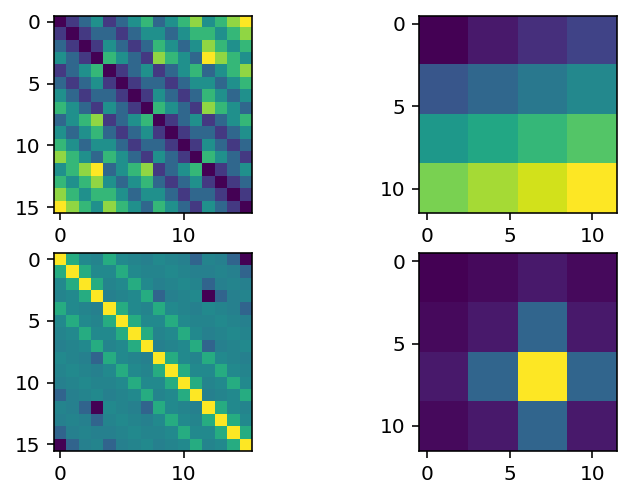

In [48]:
# 2D Visualization
# show 4 different dimensions of the positional encoding
plt.subplot(221)
plt.imshow(dist_matrix)
plt.subplot(222)
plt.imshow(grids_matrix)
plt.subplot(223)
plt.imshow(pf_matrix)
plt.subplot(224)
plt.imshow(penalty_masks[0,8,7,:,:])

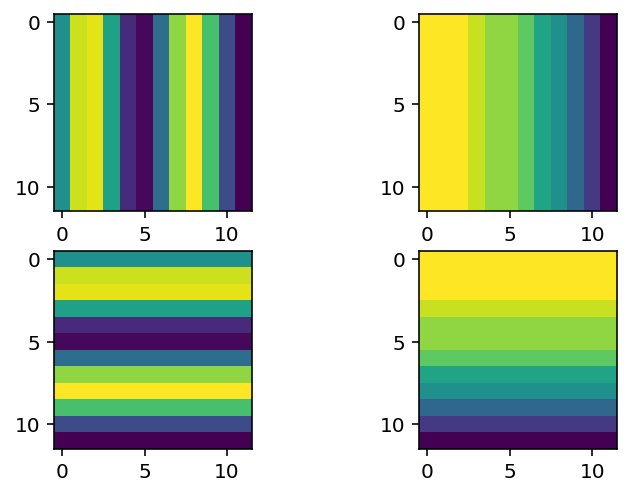

In [44]:
# 2D Visualization
# show 4 different dimensions of the positional encoding
plt.subplot(221)
plt.imshow(pos[0,0,:,:])
plt.subplot(222)
plt.imshow(pos[0,255,:,:])
plt.subplot(223)
plt.imshow(pos[0,256,:,:])
plt.subplot(224)
plt.imshow(pos[0,511,:,:])

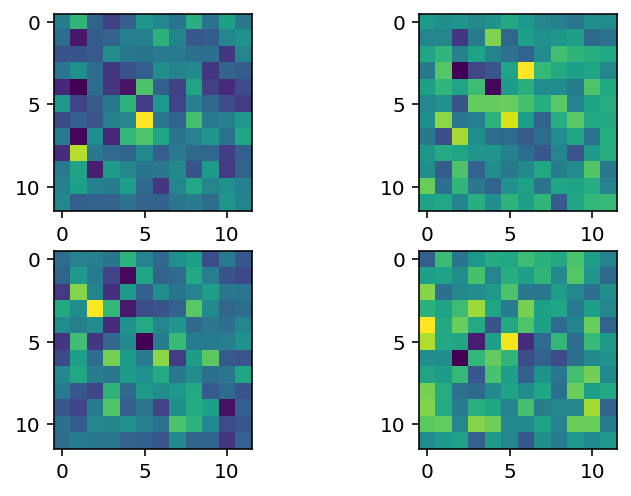

In [17]:
# 2D Visualization
# show 4 different dimensions of the backbone output
f_maps_view = f_map.squeeze(0)
plt.subplot(221)
plt.imshow(f_maps_view[0,:,:])
plt.subplot(222)
plt.imshow(f_maps_view[63,:,:])
plt.subplot(223)
plt.imshow(f_maps_view[64,:,:])
plt.subplot(224)
plt.imshow(f_maps_view[127,:,:])

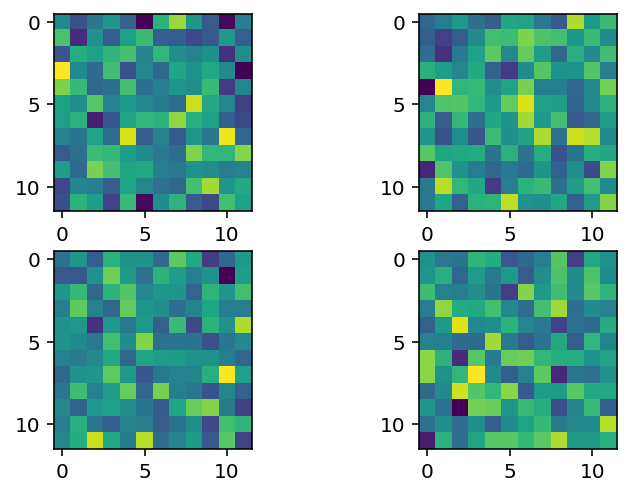

In [18]:
# 2D Visualization
# show 4 different dimensions of the encoder output
plt.subplot(221)
plt.imshow(att[0,0,:,:])
plt.subplot(222)
plt.imshow(att[0,255,:,:])
plt.subplot(223)
plt.imshow(att[0,256,:,:])
plt.subplot(224)
plt.imshow(att[0,511,:,:])

Self-attention torch.Size([1, 12, 12, 12, 12])


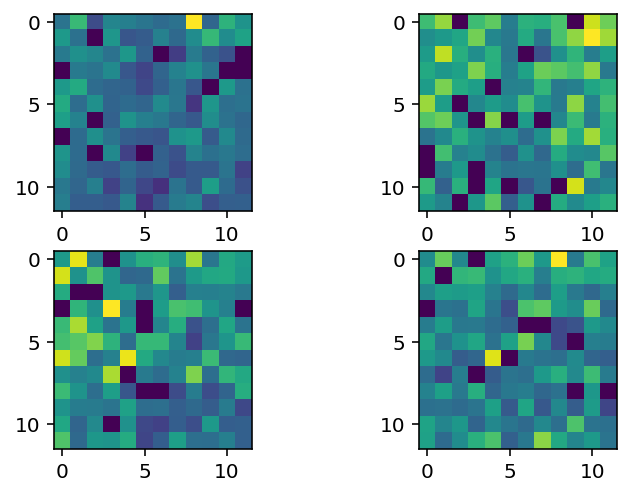

In [19]:
print("Self-attention", sattn.shape)
plt.subplot(221)
plt.imshow(sattn[0,...,0,0])
plt.subplot(222)
plt.imshow(sattn[0,...,0,11])
plt.subplot(223)
plt.imshow(sattn[0,...,11,0])
plt.subplot(224)
plt.imshow(sattn[0,...,11,11])

In [20]:
A = sattn
A.shape
#([2, 3, 8, 8])

#temp = A.view(2, 3, 32, 2)
#ind  = np.arange(32)
#ind2 = ind.reshape(8, 4).T.reshape(16, 2)
#B = temp[:, :, ind2, :]
#B2.shape

torch.Size([1, 12, 12, 12, 12])

In [21]:
grid_l = 3
grid_temp = A.shape[2]*A.shape[3]//grid_l
grid_temp

48

In [22]:
temp = A.view(A.shape[0], A.shape[1]*A.shape[2], grid_temp, grid_l)
print(temp.shape)
ind  = np.arange(grid_temp)
print(ind.shape)
ind2 = ind.reshape(A.shape[2], grid_temp//A.shape[2]).T.reshape(grid_temp//grid_l, grid_l)
print(ind2.shape)
B = temp[:, :, ind2, :]
print(B.shape)

torch.Size([1, 144, 48, 3])
(48,)
(16, 3)
torch.Size([1, 144, 16, 3, 3])


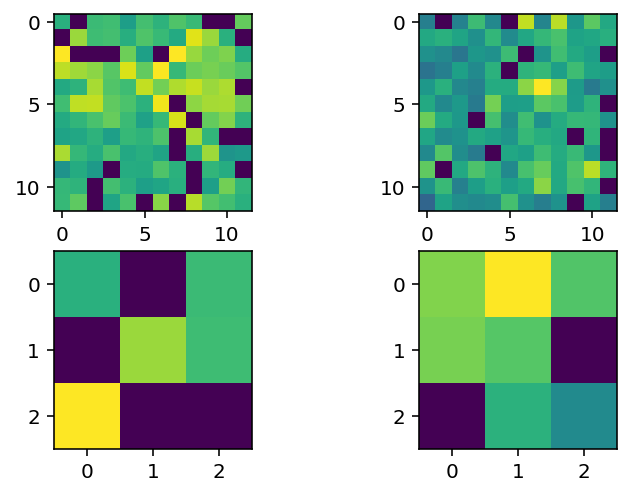

In [23]:
# 2D Visualization
# show 4 different dimensions of the encoder output
plt.subplot(221)
plt.imshow(A[0,0,0,:,:])
plt.subplot(222)
plt.imshow(A[0,11,11,:,:])
plt.subplot(223)
plt.imshow(B[0,0,0,:,:])
plt.subplot(224)
plt.imshow(B[0,143,15,:,:])

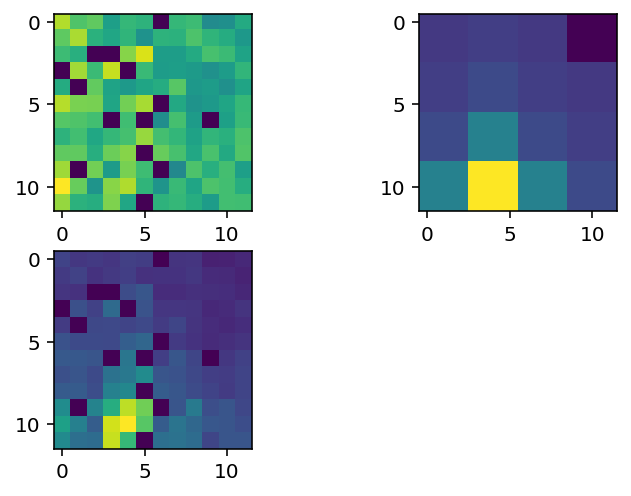

In [53]:
p1h = 11
p1w = 4

plt.subplot(221)
plt.imshow(sattn[0,p1h,p1w,...])
plt.subplot(222)
plt.imshow(penalty_masks[0,p1h,p1w,...])
plt.subplot(223)
plt.imshow(pattn[0,p1h,p1w,...])

In [49]:
torch.sum(pattn[0,p1h,p1w,...])

tensor(0.3480)

In [12]:
from models.losses import Generator_loss

In [18]:
loss = Generator_loss(beta=0.1,sigma=1)

In [19]:
Lgen = loss(pattn,noise,img)

In [20]:
Lgen

tensor(5.6986)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


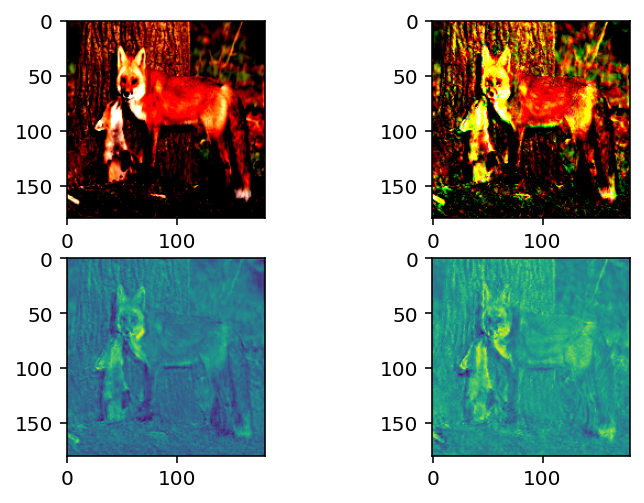

In [13]:
# 2D Visualization
# show 4 different dimensions of the encoder output
plt.subplot(221)
plt.imshow(img[0].permute(1, 2, 0))
plt.subplot(222)
plt.imshow(noise[0].permute(1, 2, 0))
plt.subplot(223)
plt.imshow(noise[0,1,:,:])
plt.subplot(224)
plt.imshow(noise[0,2,:,:])